<a href="https://colab.research.google.com/github/lauramsromano/linear_regression_enem/blob/main/Aplica%C3%A7%C3%A3o_Regress%C3%A3o_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão Linear

> Feito por: Laura Maria de Souza Romano

📧 e-mail - laura.sromano@hotmail.com
🔗
[linkedin](https://www.linkedin.com/in/laura-maria-de-souza-romano/)

---

O objetivo é utilizar os dados disponíveis para criar um modelo de regressão linear que estabeleça uma relação entre as variáveis preditoras, que podem ser características dos estudantes ou outros atributos relevantes presentes na base de dados do ENEM, e a variável de interesse, que é a nota de matemática.

A regressão linear é uma técnica estatística que busca traçar a melhor linha reta que representa a relação entre as variáveis, permitindo fazer previsões sobre os valores de uma variável com base nos valores das outras.

Para alcançar esse objetivo, será necessário realizar a preparação dos dados, tratando eventuais valores faltantes ou outliers, selecionando as variáveis mais relevantes para a previsão e separando os dados em conjuntos de treinamento e teste.

Em seguida, construiremos o modelo de regressão linear e o treinaremos usando o conjunto de treinamento, ajustando os coeficientes da reta para melhor se ajustarem aos dados disponíveis.

Uma vez que o modelo estiver treinado, iremos avaliar seu desempenho utilizando métricas apropriadas, como o erro médio quadrático ou o coeficiente de determinação (R²), para verificar quão bem ele é capaz de prever as notas de matemática com base nos dados de entrada.

Ao final, com as conclusões sobre o desempenho do modelo, poderemos utilizá-lo para fazer previsões precisas sobre as notas de matemática de novos estudantes com base em seus dados cadastrados no ENEM, fornecendo informações valiosas para análise e tomada de decisões no contexto educacional.

> Base - https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/enem


In [ ]:
# bibliotecas padrões:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# regressão:
from sklearn.linear_model import LinearRegression # regressão linear
from sklearn.linear_model import Lasso # regressão Lasso
from sklearn.model_selection import train_test_split  # divisão treino teste
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #validação do modelo (R², RMSE e MAE)

# pipeline:
from sklearn.pipeline import Pipeline # gerando pipeline
from sklearn.pipeline import make_pipeline # extraindo infos da pipeline
from sklearn.compose import ColumnTransformer # agrupação de métodos para pipeline

# processamento de variáveis numéricas:
from sklearn.preprocessing import RobustScaler # ajuste da escala das features
from sklearn.preprocessing import power_transform # normalizando target

# processamento de variáveis nominais:
!pip install category_encoders
from category_encoders import CountEncoder # transformação por frequencia

# testando multicolinearidade:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # verificação de multicolinearidade

# testando normalidade (resíduos e variáveis):
import scipy.stats as stats
from scipy.stats import shapiro # teste de normalidade

# warnings:
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Análise e tratamento da base:

Neste tópico realizamos os seguintes processos:

- Importação dos dados e criação da base para **tratamento e modelagem**.
- Escolha e ajuste nas **features**.
- **Levantementos gerais** sobres informações da base criada.

In [ ]:
# leitura da base
amostra = pd.read_csv('amostra_enem_bahia.csv')

# filtra apenas alunos de escolas públicas ou privadas
amostra = amostra[amostra.TP_ESCOLA.isin([2, 3])]

# filtra alunos que não obtiveram 0 em Matemática e em Ciências da Natureza e alunos com mais de 14 anos
amostra = amostra.query('(NU_NOTA_MT != 0) & (NU_IDADE >= 14) & (NU_NOTA_CN != 0)')

In [ ]:
# prepara a base para aplicar o modelo
base_amostra = pd.DataFrame()
base_amostra['dummy_sexo_feminino'] = amostra.TP_SEXO.map({'F': 1, 'M': 0})
base_amostra['municipio_residencia'] = amostra.NO_MUNICIPIO_RESIDENCIA
base_amostra['idade'] = amostra.NU_IDADE
base_amostra['cor_raca'] = amostra['TP_COR_RACA']
base_amostra['escola_publica'] = amostra['TP_ESCOLA'].map({3: 0, 2: 1})
base_amostra['nota_matematica'] = amostra['NU_NOTA_MT']
base_amostra['nota_ciencia'] = amostra['NU_NOTA_CN']
base_amostra['escolaridade_pai'] = amostra.Q001.map({'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': 1, 'H': 0})
base_amostra['escolaridade_mae'] = amostra.Q002.map({'A': 0, 'B': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': 1, 'H': 0})
base_amostra['tamanho_familia'] = amostra.Q005
base_amostra['internet'] = amostra.Q025.map({'A': 0, 'B': 1})
base_amostra['computador'] = amostra.Q024.map({'A': 0, 'B': 1, 'C': 1, 'D': 1, 'E': 1})
base_amostra.dropna(inplace = True)
values_to_map = {value: index for index, value in enumerate(np.sort(amostra.Q006.astype(str).unique()), start=1)}
base_amostra['renda_familiar'] = amostra.Q006.astype(str).map(values_to_map)

In [ ]:
base_amostra.head()

,dummy_sexo_feminino,municipio_residencia,idade,cor_raca,escola_publica,nota_matematica,nota_ciencia,escolaridade_pai,escolaridade_mae,tamanho_familia,internet,computador,renda_familiar
3,0,Lauro de Freitas,17.0,2,1,704.5,567.3,1,0,2,1,0,2
7,0,São Sebastião do Passé,19.0,3,1,392.5,361.2,0,0,5,1,0,2
22,1,Salvador,18.0,3,1,425.2,523.6,1,0,6,1,0,3
28,0,Serrinha,19.0,2,1,386.4,525.0,0,1,3,1,1,2
43,0,Itapetinga,17.0,2,1,441.9,378.6,0,0,3,0,0,2


In [ ]:
base_amostra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78526 entries, 3 to 250103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dummy_sexo_feminino   78526 non-null  int64  
 1   municipio_residencia  78526 non-null  object 
 2   idade                 78526 non-null  float64
 3   cor_raca              78526 non-null  int64  
 4   escola_publica        78526 non-null  int64  
 5   nota_matematica       78526 non-null  float64
 6   nota_ciencia          78526 non-null  float64
 7   escolaridade_pai      78526 non-null  int64  
 8   escolaridade_mae      78526 non-null  int64  
 9   tamanho_familia       78526 non-null  int64  
 10  internet              78526 non-null  int64  
 11  computador            78526 non-null  int64  
 12  renda_familiar        78526 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 8.4+ MB


In [ ]:
base_amostra.shape

(78526, 13)

In [ ]:
base_amostra.isnull().sum()

dummy_sexo_feminino     0
municipio_residencia    0
idade                   0
cor_raca                0
escola_publica          0
nota_matematica         0
nota_ciencia            0
escolaridade_pai        0
escolaridade_mae        0
tamanho_familia         0
internet                0
computador              0
renda_familiar          0
dtype: int64

#### Preparandos os dados e treinando o modelo.

Neste tópico realizamos os seguintes processos:

- Separando os dados em bases de treino e de teste para tratamento e treinamento do modelo.
- Tratando a target **'nota_matematica'** aplicando logarítmo.
- Tratandos a variável **'municipio_residencia'**, uma variável qualitativa nominal, com o método *'CountEncoder'*.
- Tratando as variáveis **'idade'**, **'tamanho_familia'**,  e **'nota_ciencia'** , variáveis quantitativas discretas com método *'RobustScaler'*.

As variáveis **'dummy_sexy_feminino'**, **'cor_raca**', **'escolha_publica**', **'escolaridade_pai'**, **'escolaridade_mae'**, **'internet**' e **'computador'** já foram tratadas na construção da base a partir da amostra de dados, de forma que não é necessário nenhum processamento posterior.


##### Target:

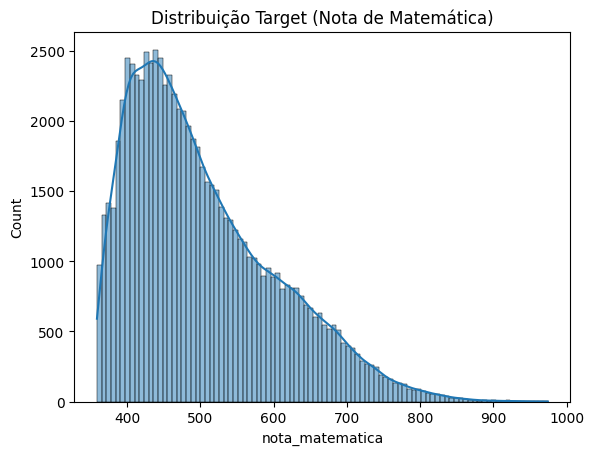

In [ ]:
# Verificando distribuição da target:
sns.histplot(base_amostra['nota_matematica'], kde=True)
plt.title('Distribuição Target (Nota de Matemática)')
plt.show()


Vemos pelo gráfico acima que a target possui uma distribuição assimétrica, apresentando calda a direita.

Ao aplicar logarítimo, **é possível reduzir essa assimetria, tornando a distribuição mais próxima de uma distribuição normal**.

Quando a target possui uma distribuição mais próxima da normal, é mais provável que os resíduos também sigam essa distribuição, o que é consistente com a **suposição da regressão linear.** Iremos verificar isso mais adiante.

In [ ]:
# base de treino e de teste:
X = base_amostra.drop(columns = ['nota_matematica']) # features
y = np.log(base_amostra.nota_matematica) # target

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 1,
                                                    test_size = 0.3)

In [ ]:
X_train.shape, X_test.shape

((54968, 12), (23558, 12))

##### Variáveis quantitativas:

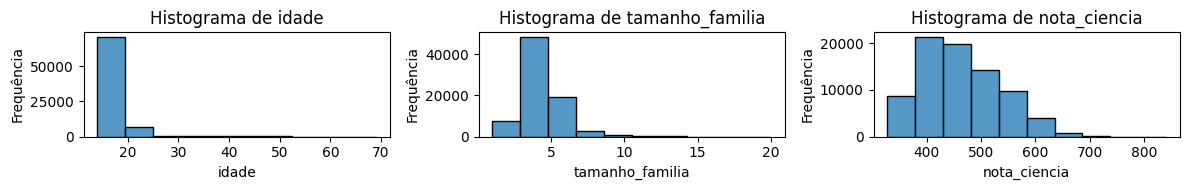

In [ ]:
# Verificando a distribuição das variáveis numéricas:

# gráficos de histograma das variáveis selecionadas
fig, axes = plt.subplots(1, 3, figsize=(12, 2))

columns_to_plot_numeric = ['idade', 'tamanho_familia', 'nota_ciencia']

for i, column in enumerate(columns_to_plot_numeric):
    ax = axes[i % 3]
    sns.histplot(base_amostra[column], bins=10, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequência')
    ax.set_title('Histograma de ' + column)

plt.tight_layout()
plt.show()


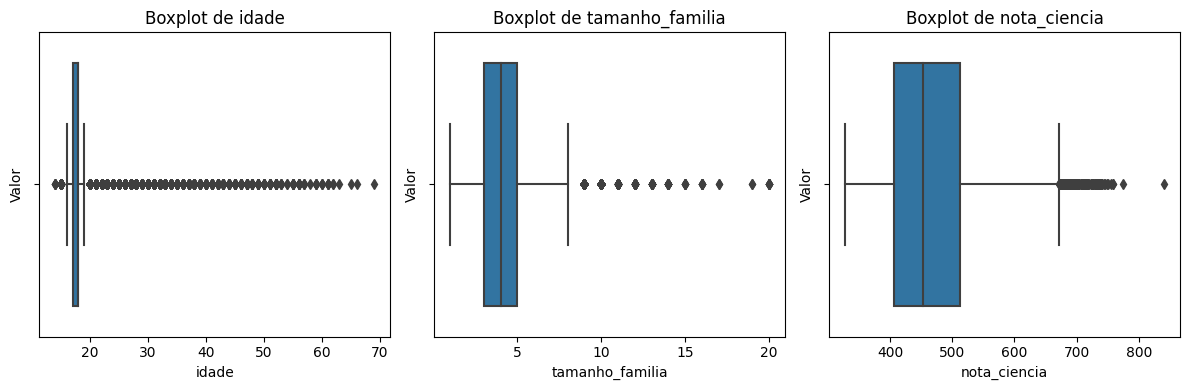

In [ ]:
# Verificando outliers:

# Boxplot das variáveis selecionadas
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

columns_to_plot_numeric = ['idade', 'tamanho_familia', 'nota_ciencia']

for i, column in enumerate(columns_to_plot_numeric):
    ax = axes[i % 3]
    sns.boxplot(x=base_amostra[column], ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Valor')
    ax.set_title('Boxplot de ' + column)

plt.tight_layout()
plt.show()


É possível verificar que as variáveis possuem uma **distribuição assimétrica**, apresentando caldas a direita.

Pelo boxplot também validamos que **há presença de outilers** nos dados.

> Dessa forma, é necessária a aplicação do método *'RobustScaler'* **para dimensionar as variáveis**. O uso do RobustScaler pode ajudar a melhorar o desempenho do modelo, **garantindo que os dados sejam adequadamente escalonados e considerando a presença de valores atípicos (outilers).**


##### Variáveis qualitativas:

In [ ]:
base_amostra['municipio_residencia']

3               Lauro de Freitas
7         São Sebastião do Passé
22                      Salvador
28                      Serrinha
43                    Itapetinga
                   ...          
250072                     Lapão
250075                  Salvador
250086                   Itabuna
250099                   Caetité
250103              Simões Filho
Name: municipio_residencia, Length: 78526, dtype: object

Dentre as features, temos a variável **'municipio_residencia'** que, inicialmente, está no **formato qualitativo nominal.**

No entanto, para aplicarmos o modelo de regressão, **é necessário realizar o tratamento dessas informações.**

> Para isso foi escolhido o método 'CountEncoder' que irá transformar as categorias presentes na variável 'municipio_residencia' em **valores numéricos correspondentes à contagem de ocorrências de cada categoria no conjunto de dados.** Cada categoria será substituída pelo número de instâncias em que ela ocorre. Essa transformação permitirá que a variável seja utilizada no modelo de regressão linear, já que será representada de forma numérica.




Para aplicar as tranformações necessárias iremos criar um pipeline, conforme abaixo:

In [ ]:
# aplicando CountEncoder na variável nominal:
columns_to_encode = ['municipio_residencia']

# aplicando RobustScaler nas variáveis numéricas:
columns_to_scale_numeric = ['idade', 'tamanho_familia', 'nota_ciencia']

# criar o transformador para aplicar as transformações
transformer = ColumnTransformer(
    transformers=[
        ('count_encoder', CountEncoder(), columns_to_encode),
        ('robust_scaler', RobustScaler(), columns_to_scale_numeric)
    ],
    remainder='passthrough'
)

# criando o pipeline com o transformador e o modelo
pipeline = Pipeline([
    ('transformer', transformer),
    ('model', LinearRegression())
])

# ajustar o pipeline aos dados de treino
pipeline.fit(X_train, y_train)

# prever os valores de saída para os dados de teste
y_pred = pipeline.predict(X_test)

#### Pré-supostos para aplicação da regressão:

O próximo passo é realizar as verificações para validação e confiabilidade da regressão realizada, ou seja, **se os coeficientes são de fato representativos.**

Para isso, os resíduos devem:

- **Variância constante:** todos os resíduos têm a mesma variância.
- **Normalidade:** os resíduos são normalmente distribuídos.

E para as features:

- **Sem multicolinearidade:** as variáveis independentes não devem ser correlacionadas umas com as outras.


In [ ]:
# calculo dos resíduos:
resid = y_test - y_pred
resid

188959    0.125495
51600    -0.072019
33640    -0.133108
54067    -0.080938
144568   -0.118001
            ...   
93080    -0.144789
34080     0.029640
71622    -0.019313
169366    0.200693
197293    0.039491
Name: nota_matematica, Length: 23558, dtype: float64

In [ ]:
# comparação valores reais, previsos e seus respectivos resíduos:
comparacao = pd.DataFrame({'Valores reais (y)': y_test, 'Valores previstos (y)': y_pred, 'Resíduo': resid})
comparacao

,Valores reais (y),Valores previstos (y),Resíduo
188959,6.512042,6.386548,0.125495
51600,6.096050,6.168069,-0.072019
33640,6.005860,6.138969,-0.133108
54067,6.075346,6.156284,-0.080938
144568,6.084955,6.202956,-0.118001
...,...,...,...
93080,5.985195,6.129984,-0.144789
34080,6.333990,6.304350,0.029640
71622,6.164367,6.183680,-0.019313
169366,6.486313,6.285620,0.200693


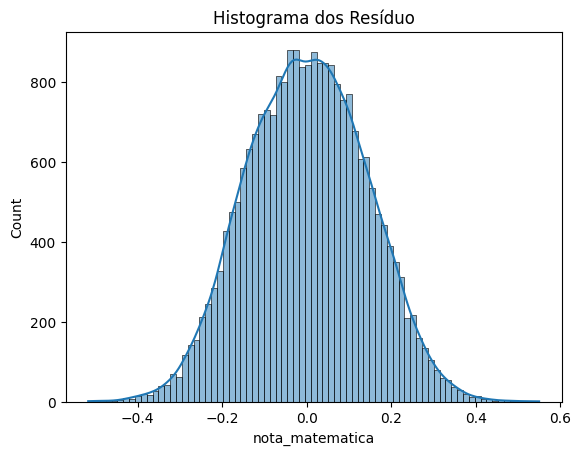

In [ ]:
# Verificar a distribuição dos residuos
sns.histplot(resid, kde=True)
plt.title('Histograma dos Resíduo')
plt.show()

In [ ]:
# testando a normalidade dos resíduos - Shapiro-Wilk:
stat, p_valor = shapiro(resid)

print("Estatística de teste:", stat)
print("Valor p:", p_valor)

if p_valor > 0.05:
    print("Os resíduos seguem uma distribuição normal.")
else:
    print("Os resíduos não seguem uma distribuição normal.")

Estatística de teste: 0.9989578127861023
Valor p: 4.9703952759161396e-11
Os resíduos não seguem uma distribuição normal.


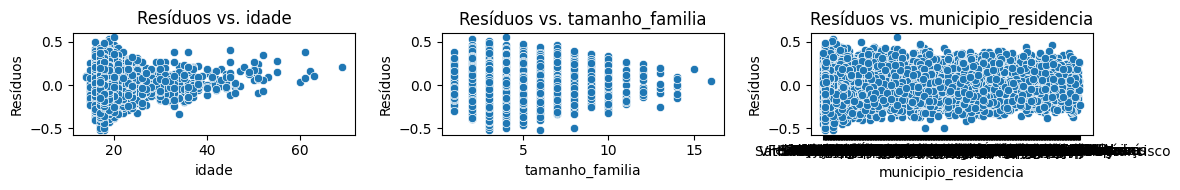

In [ ]:
# gráficos de residuo vs x's para variáveis numéricas
fig, axes = plt.subplots(1, 3, figsize=(12, 2))

columns_to_plot = ['idade', 'tamanho_familia', 'municipio_residencia']

for i, column in enumerate(columns_to_plot):
    ax = axes[i % 3]
    sns.scatterplot(x=X_test[column], y=resid, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Resíduos')
    ax.set_title('Resíduos vs. ' + column)

plt.tight_layout()
plt.show()


In [ ]:
# Verificando multicolinearidade das variáveis - VIF

# extraindo as infos de X tratadas no pipeline
X_train_transformed = pipeline.named_steps['transformer'].transform(X_train)
X_train_transformed

# calculando vif
vif_data = pd.DataFrame()
vif_data["Variável"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_transformed, i)
                   for i in range(X_train_transformed.shape[1])]

vif_data["Conclusão"] = ["Não há multicolinearidade"
                          if v == 1 else "Nível moderado de multicolinearidade"
                          if 1 < v < 5 else "Alta multicolinearidade"
                          for v in vif_data["VIF"]]

vif_data

,Variável,VIF,Conclusão
0,dummy_sexo_feminino,1.511457,Nível moderado de multicolinearidade
1,municipio_residencia,1.061240,Nível moderado de multicolinearidade
2,idade,1.037470,Nível moderado de multicolinearidade
3,cor_raca,1.396802,Nível moderado de multicolinearidade
4,escola_publica,2.437401,Nível moderado de multicolinearidade
5,nota_ciencia,5.939957,Alta multicolinearidade
6,escolaridade_pai,5.146558,Alta multicolinearidade
7,escolaridade_mae,2.237671,Nível moderado de multicolinearidade
8,tamanho_familia,3.026351,Nível moderado de multicolinearidade
9,internet,4.888540,Nível moderado de multicolinearidade


##### Resumo das concluções sobre os resíduos e as features:

A partir do teste Shapiro vericamos que **não há normalidade nos resíduos.**

Para **'idade'** e **'tamanho_familia'** vemos um padrão de funil,
o que caracterisa uma heterocedasticidade, ou seja, resíduos com
**variância não constante**.

Para **'municipio_residencia'** já não é possível verificar uma padronização tão forte.

> Com isso, **violamos a suposição de homocedasticidade**, ou seja, a variância constante dos erros (resíduos) em todos os níveis das variáveis independentes. Se essa suposição não for atendida, as estimativas dos coeficientes de regressão podem ser ineficientes e enviesadas. **Isso significa que as estimativas dos coeficientes podem não ser tão precisas e confiáveis quanto se esperava.**

É dificil a hipotese da normalidade dos resíduos se confirmar na prática, mas a Lei dos Grandes Números garante que em amostras grandes o suficiente a distribuição vai se assemelhar à normal. A falha dessa violação **não significa que o modelo deve ser descartado, apenas que os resultados são válidos assintoticamente, ou seja, em amostras grandes o suficiente** - como é o caso.

Outro ponto importante é compreender que podemos estar lidando com **endogeneidade**, ou seja, há alguma variável que influencia a nossa target que pode não está presente no modelo.

Por fim, verificamos também que as variáveis **'escolaridade_mae'** e **'escolaridade_pai'** possuem uma alta multicolinearidade (>5), podendo influenciar nos coeficientes e nas métrica do modelo.

Após as conclusões acima, seguimos com a aplicação do modelo nos dados de teste e validação das métricas escolhidas.

####  Métricas para validação dos resultados da regressão:

Para avaliar a eficiência do modelo, iremos utilizar as métricas abaixo:

R², RMSE e MAE:

- **R²**: proporção da variância da variável target explicada pelas features do modelo. Buscamos maximizar, ou seja, **quanto mais próximo de 1, melhor**.
- **RMSE**: raiz da média da diferença quadrática entre os valores reais e os valores ajustados. Buscamos minimizar, **quanto mais próximo de 0, melhor**.
- **MAE**: média das diferenças absolutas entre as previsões do modelo e os valores reais. Buscamos minimizar, **quanto mais próximo de 0, melhor**.

In [ ]:
# define uma função para calcular o rmse
def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)

In [ ]:
# previsão com os dados de treino
y_pred_train = pipeline.predict(X_train)
# previsão com os dados de teste
y_pred_test = pipeline.predict(X_test)

y_pred_train, y_pred_test

(array([6.13552211, 6.10969111, 6.25363395, ..., 6.37337078, 6.19768784,
        5.99986386]),
 array([6.38654773, 6.16806874, 6.13896879, ..., 6.18367999, 6.28561992,
        6.3091238 ]))

In [ ]:
# calculo o RMSE
rmse_train = rmse(y_train, y_pred_train)
rmse_test = rmse(y_test, y_pred_test)

rmse_train, rmse_test

(0.141, 0.1406)

In [ ]:
# métrica nos dados de treino e teste
r_train = pipeline.score(X_train, y_train)
r_test = pipeline.score(X_test, y_test)
# modelo.score(X_train, y_train), modelo.score(X_test, y_test)

r_train, r_test

(0.4445279305248321, 0.4450600098336043)

In [ ]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

mae_train, mae_test

(0.11488286384222314, 0.11406652353355062)

In [ ]:
results_df = pd.DataFrame({'R2': [r_train, r_test], 'RMSE': [rmse_train, rmse_test], 'MAE': [mae_train, mae_test]}, index=['Treino', 'Teste'])
results_df

,R2,RMSE,MAE
Treino,0.444528,0.1410,0.114883
Teste,0.445060,0.1406,0.114067


#### Conclusões sobre o modelo:

> Para o R² obtivemos para dados de treino e teste os valores de 0.444 e 0.445 respectivamente, **indicando que o modelo explica aproximadamente 44% da variabilidade dos dados em ambos os conjuntos**. Isso sugere que o modelo possui uma capacidade razoável de explicar a variabilidade dos dados e apresenta uma boa generalização para novos conjuntos de dados.

> Para RMSE obtivemos para dados de treino e teste os valores de 0.1410 e 0.1406, respectivamente, **o que indica que o modelo está tendo facilidade em fazer boas previsões**, além de demonstrar que o modelo está generalizando bem e possui um desempenho semelhante em ambos os conjuntos.

> Para o MAE obtivemos para dados de treino e teste os valores de 0.114 respectivamente, **o que indica que em média, as predições do modelo estão desviando aproximadamente 0.114 unidades em relação aos valores reais.**



Conforme pontuando anteriormente, as variáveis **'escolaridade_mae'** e **'escolaridade_pai'** possuem uma alta multicolinearidade.

Dessa forma é necessário o tratamento desta questão para buscarmos melhores resultados no modelo. Iremos então fazer a **regularização dos coeficiente** com a regressão Lasso.

Iremos utilizar o método de **validação cruzada para encontrar um alpha que melhor ajuste os coeficientes.**

#### Regularização e validação cruzada:

In [ ]:
# validação cruzadas
def test_regularizacao(pipeline):

    list_alpha = [0.0001, 0.001, 0.1, 1, 5, 10, 15, 20, 30, 45, 50, 60, 70, 80, 90]
    result_df = pd.DataFrame(columns=['alpha', 'r2_train', 'r2_test', 'RMSE_train', 'RMSE_test'])

    for alpha_number in list_alpha:
        # definir o valor de alpha no modelo Lasso
        pipeline.named_steps['model'].set_params(alpha=alpha_number)

        # ajustar o pipeline aos dados de treinamento
        pipeline.fit(X_train, y_train)

        # prever os valores de treinamento e teste
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)

        # calcular R² e RMSE
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)

        # armazenar os resultados
        result = pd.DataFrame({'alpha': [alpha_number],
                               'r2_train': [r2_train],
                               'r2_test': [r2_test],
                               'RMSE_train': [RMSE_train],
                               'RMSE_test': [RMSE_test],
                               'MAE_train': [mae_train],
                               'MAE_test': [mae_test]
                              })
        result_df = result_df.append(result)

    result_df = result_df.round(4).reset_index(drop=True)
    return result_df

In [ ]:
# Ajuste da pipeline para regressão lasso:

# aplicando CountEncoder na variável nominal:
columns_to_encode = ['municipio_residencia']

# aplicando RobustScaler nas variáveis numéricas:
columns_to_scale_numeric = ['idade', 'tamanho_familia', 'nota_ciencia', 'renda_familiar']

# criar o transformador para aplicar as transformações
transformer = ColumnTransformer(
    transformers=[
        ('count_encoder', CountEncoder(), columns_to_encode),
        ('robust_scaler', RobustScaler(), columns_to_scale_numeric)
    ],
    remainder='passthrough'
)

# criando o pipeline com o transformador e o modelo
pipeline = Pipeline([
    ('transformer', transformer),
    ('model', Lasso())
])

In [ ]:
result_df = test_regularizacao(pipeline)
result_df

,alpha,r2_train,r2_test,RMSE_train,RMSE_test,MAE_train,MAE_test
0,0.0001,0.4445,0.4451,0.1410,0.1406,0.1149,0.1141
1,0.0010,0.4439,0.4447,0.1411,0.1406,0.1151,0.1143
2,0.1000,0.0835,0.0820,0.1811,0.1808,0.1505,0.1504
3,1.0000,0.0171,0.0148,0.1876,0.1873,0.1553,0.1554
4,5.0000,0.0170,0.0149,0.1876,0.1873,0.1553,0.1554
5,10.0000,0.0169,0.0149,0.1876,0.1873,0.1553,0.1554
6,15.0000,0.0167,0.0148,0.1876,0.1873,0.1554,0.1554
7,20.0000,0.0165,0.0147,0.1876,0.1873,0.1554,0.1554
8,30.0000,0.0157,0.0141,0.1877,0.1873,0.1555,0.1555
9,45.0000,0.0140,0.0128,0.1879,0.1875,0.1556,0.1556


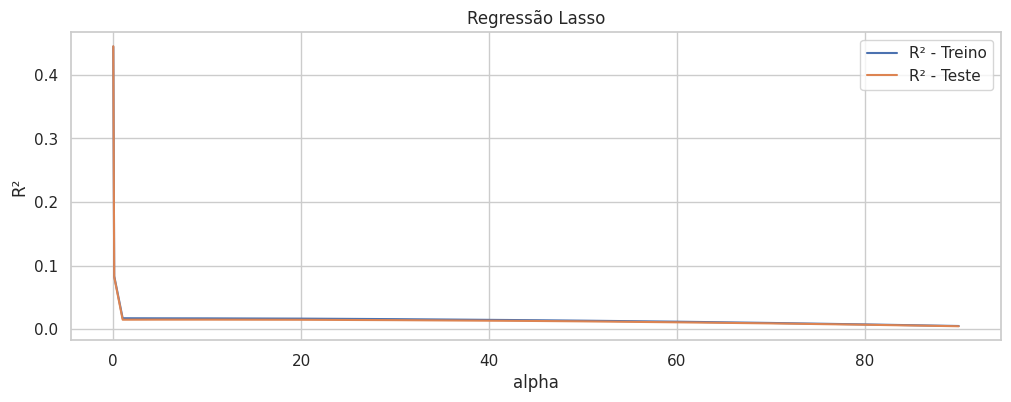

In [ ]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(data=result_df, x='alpha', y='r2_train', ax=ax, label='R² - Treino')
sns.lineplot(data=result_df, x='alpha', y='r2_test', ax=ax, label='R² - Teste')

ax.set_title('Regressão Lasso')
ax.set_xlabel('alpha')
ax.set_ylabel('R²')

plt.show()

É importante compreender que quanto maior o alfa menores serão os R².
Isso caracteriza uma queda na performance do modelo (underfitting), como pode ser visto no gráfico acima.

> Ou seja, é necessário encontrar valor de alfa para equilibrar o modelo e torná-lo mais eficiente, encontrando o alpha que traga **o maior R² com os menores MAE e RMSE possíveis.** Conforme tabela, o alpha seria 0.0001.

Contudo, os valores de RMSE, MAE e R² da regressão Lasso com o alpha de 0.0001 são muito próximos ou iguais aos valores da regressão linear padrão realizada anteriormente.

Modelo|R² teste|R² treino|RMSE teste|RMSE treino|MAE treino|MAE teste|
------|------|------|---------------|---------------|--------------|--------------|
Regressão Linear|0.4451|0.1406|0.4445|0.1410|0.1148|0.1140
Regressão Lasso|0.4451|0.1406|0.4445|0.1410 |0.1149|0.1141

> Ou seja, a aplicação da regressão Lasso com um valor de alpha de 0.0001 não resultou em uma melhora significativa em relação à regressão linear padrão. Isso significa que a regularização não trouxe benefícios perceptíveis na redução do erro (RMSE e MAE) ou no ajuste do modelo (R²).

> Nesse caso. a **regressão linear sem regularização parece ser suficiente para descrever os dados de forma adequada.**